In [1]:
import ROOT, rat
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline 
sys.path.append('/home/jp/projects/python_tools')
sys.path.append('/home/jp/projects/snoplus/python_modules')
import jp_mpl as jplot
from jp_analysis import *
from greydisc_functions import *
import rat
from itertools import cycle
from scipy.stats import truncnorm
plt.rcParams['image.cmap'] = 'YlOrRd'

TClass::TClass:0: RuntimeWarning: no dictionary for class omtext is available


###  Start here if you have already loaded/selected the tracks

In [2]:
data = pickle.load(open('/home/jp/projects/snoplus/rundir/greydisc_validation/onepmt_geo/condensed_337nm.pckl'))


In [3]:
# The momentum is not a unit vector. Don't know why. Renormalizing it
momentum_norm = np.linalg.norm(data['momentum'],axis=1)
momentum_norm = momentum_norm.reshape(momentum_norm.size, 1)
data['momentum'] /= momentum_norm
my_times = np.zeros_like(data['r'])
my_z     = np.zeros_like(my_times)
for ievent in range(len(data['r'])):
    x0 = data['x'][ievent]
    y0 = data['y'][ievent]
    z0 = 130.4

    u = data['momentum'][ievent,0]
    v = data['momentum'][ievent,1]
    w = data['momentum'][ievent,2]
    t = pmtContactTime(x0,y0,z0, u,v,w)
    z = pmtContactDepth(z0, w, t)
    my_times[ievent] = t
    my_z[ievent] = z

In [4]:
pmt_hits = (my_z < 100)
conc_hits = (my_z > 100)

print 'PMT hits', np.sum(pmt_hits)
print 'Concentrator hits', np.sum(conc_hits)


PMT hits 6837
Concentrator hits 61557


In [5]:
data['nsteps'] = np.ceil(data['nsteps']/7)-1

In [74]:
data.keys()

['theta_f',
 'y',
 'delta_t',
 'phi_f',
 'theta_i',
 'xr',
 'r',
 'phidiff',
 'phi_i',
 'x',
 'nsteps',
 'momentum']

In [77]:
data['my_times'] = my_times

/home/jp/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:6365: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


18.5
Everything below 26mm actually hit the concentrator


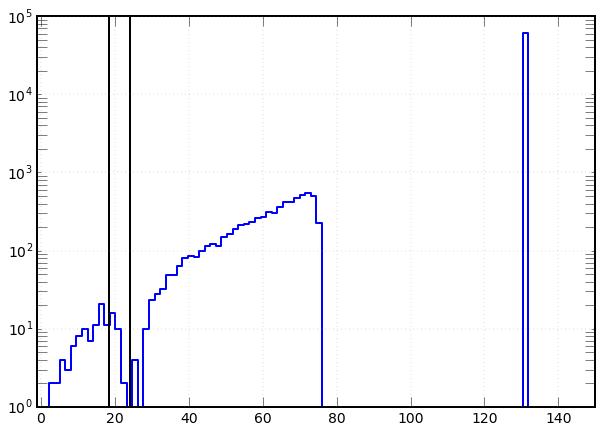

In [76]:
plt.figure(figsize=(10,7))
xaxis = np.linspace(-1, 150, 101)
b, x = np.histogram(my_z, xaxis)
jplot.unfilledBar(x,b)
plt.yscale('log')
plt.axvline(131.8-113.3, 0.001, 1000, color='k')
plt.axvline(24, 0.001, 1000, color='k')
print 131.8-113.3
print 'Everything below 26mm actually hit the concentrator'

# PMT Hit first

In [48]:
sel=( np.array([True]*len(data['y']))
     *pmt_hits
     #*(data['r']>0)
    )

### Estimating the number of reflections 

Trying to obtain an estimator of the number of steps for the HIT PMT photons


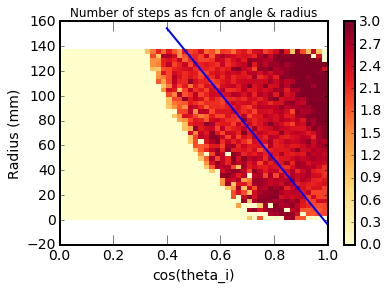

In [49]:
print 'Trying to obtain an estimator of the number of steps for the HIT PMT photons'
xvalues = np.cos(data['theta_i'][sel])
yvalues = data['r'][sel]

x = np.linspace(0, 1., 51)
y = np.linspace(0, greydisc_radius, 41)

b,x1,y1 = np.histogram2d(xvalues, yvalues, [x,y],
                       weights=data['nsteps'][sel])
b2,x1,y1 = np.histogram2d(xvalues, yvalues, [x,y])

plt.pcolor(x,y,(b/(b2+0.1)).T, vmin=0, vmax=3)


plt.colorbar()

myx = np.linspace(0.4, 1.0, 101)
plt.plot(myx, line_fcn(myx,-145/(0.95-0.4), 260.))

plt.xlabel('cos(theta_i)')
plt.ylabel('Radius (mm)')
plt.title('Number of steps as fcn of angle & radius')

1.56686777558


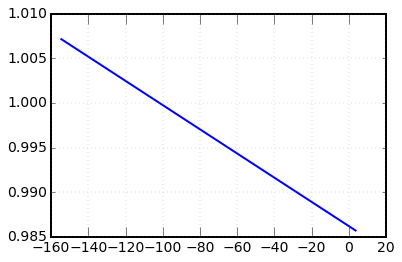

In [50]:
# Rotating the line
y_data = line_fcn(myx, -145/(0.95-0.4), 260.)
x_data = myx
rotation = np.arctan(140/0.55)
print rotation
xpp = x_data*np.cos(rotation) - y_data*np.sin(rotation)
ypp = x_data*np.sin(rotation) + y_data*np.cos(rotation)
#plt.plot(x_data, y_data)
plt.plot(xpp,ypp)


Rotating, removing one of the parameters, everything as function of theta_i
1.56686777558 89.7749105956


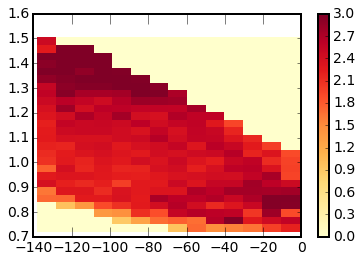

In [51]:
print 'Rotating, removing one of the parameters, everything as function of theta_i'

rotation_angle = np.arctan(140/0.55)
print rotation_angle, np.rad2deg(rotation_angle)


xprime = xvalues*np.cos(rotation_angle) - yvalues*np.sin(rotation_angle)
yprime = xvalues*np.sin(rotation_angle) + yvalues*np.cos(rotation_angle)

x = np.linspace(xprime.min(), xprime.max(), 15)
y = np.linspace(yprime.min(), yprime.max(), 27)

b,x1,y1 = np.histogram2d(xprime, yprime, [x,y],
                       weights=data['nsteps'][sel])
b2,x1,y1 = np.histogram2d(xprime, yprime, [x,y])
plt.figure()
mydata = (b/(b2+0.1)).T

plt.pcolor(x,y, mydata, vmin=0, vmax=3)
plt.colorbar()
xindex = np.where(x>-70)[0][0]
#plt.axvline(x[xindex], 0, 1.6)




Verification


/home/jp/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide


The rotation is given by
value = np.cos(data['theta_i'][sel])*np.sin(rot_angle) + data['r'][sel]*np.cos(rot_angle)
The rotation angle is 1.56686777558
The rotated values is used to evaluate this function
       2
-5.89 x + 12.14 x - 5.613
Draw a random value. If the value is higher than the function, multiple reflection


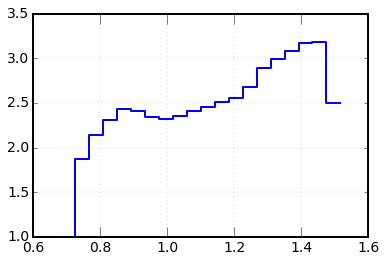

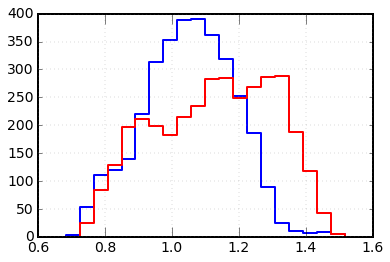

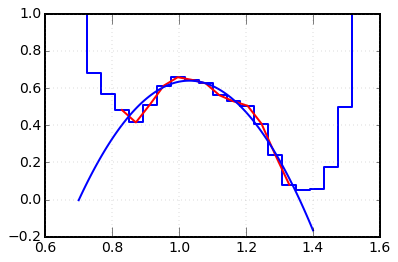

In [52]:
print 'Verification'
rot_angle = 1.56686777558#1.56686777558#1.56686777558
xp = np.cos(data['theta_i'][sel])*np.sin(rot_angle) + data['r'][sel]*np.cos(rot_angle)

xaxis = np.linspace(0.6, 1.6, 25)
xeval = np.linspace(0.6, 1.6, 201)

plt.figure()
n,x = np.histogram(xp, xaxis, weights = data['nsteps'][sel])
n2,x = np.histogram(xp, xaxis)
jplot.unfilledBar(x,n/n2)

plt.figure()
single = (data['nsteps'][sel] < 2.5)
n, x = np.histogram(xp[single], xaxis)
n2, x = np.histogram(xp[~single], xaxis)

jplot.unfilledBar(x,n, color = 'blue')
jplot.unfilledBar(x,n2, color = 'red')

plt.figure()

ratio = (n+0.01)/(n2+n+0.01)
jplot.unfilledBar(x, ratio)

xfit = (x[:-1]+x[1:])/2.
indices = [np.where(xfit>0.8)[0][0], np.where(xfit<1.4)[0][-1]]
plt.plot(xfit[indices[0]:indices[1]], ratio[indices[0]:indices[1]], '-r')

fcn = np.poly1d(np.polyfit(xfit[indices[0]:indices[1]], ratio[indices[0]:indices[1]], deg=2))
test_x = np.linspace(0.7, 1.4, 101)

plt.plot(test_x, fcn(test_x))
print "The rotation is given by\nvalue = np.cos(data['theta_i'][sel])*np.sin(rot_angle) + data['r'][sel]*np.cos(rot_angle)"
print "The rotation angle is", rot_angle
print "The rotated values is used to evaluate this function"
print fcn
print "Draw a random value. If the value is higher than the function, multiple reflection"

### Theta angle for single reflections

In [285]:
print 'Selecting only the events that hit the PMT and leave in a single reflection'
sel=( np.array([True]*len(data['y']))
     *pmt_hits
     *(data['nsteps'] < 3)
     #*(data['z'] > 0)
     #*(data['r']>80)
    )


Selecting only the events that hit the PMT and leave in a single reflection


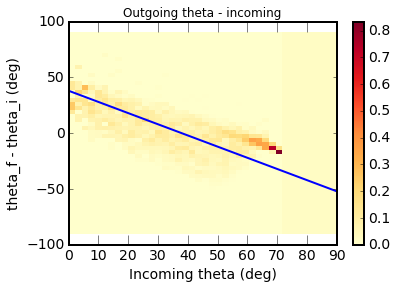

In [286]:
x1 = np.linspace(0, np.pi/2., 41)
x2 = np.linspace(-np.pi/2, np.pi/2., 51)
n, x1, x2 = np.histogram2d(data['theta_i'][sel], 
                           data['theta_f'][sel] - data['theta_i'][sel], 
                           [x1,x2])
n = renormN(n,axis=1)
plt.pcolor(np.rad2deg(x1),
           np.rad2deg(x2),
           n.T)
plt.xlabel('Incoming theta (deg)')
plt.ylabel('theta_f - theta_i (deg)')
plt.colorbar()
plt.title('Outgoing theta - incoming')
#plt.yticks(np.arange(-90, 90, 5.0))

xaxis_line = np.linspace(0, 90, 201)
yvalues = line_fcn(xaxis_line, -40./40, 38)
plt.plot(xaxis_line, yvalues)

The distribution has been rotated (delta Theta and theta in are the inputs)
The rotation is given by
new_x = data['theta_i'][sel]*np.cos(rotation_angle) - delta*np.sin(rotation_angle)
new_y = data['theta_i'][sel]*np.sin(rotation_angle) + delta*np.cos(rotation_angle)
The rotation angle is 0.785398163397

The rotated distribution is a gaussian described by
Mean 0.55561671911 Sigma 0.136814056128
Draw a random value from that distribution. That is new_y
delta = ( new_y - theta_i*np.sin(rotation_angle) ) / np.cos(rotation_angle)


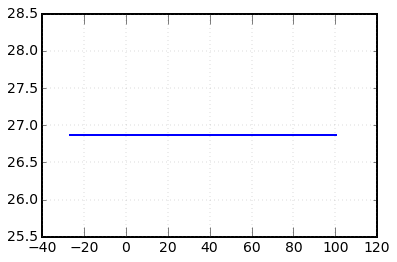

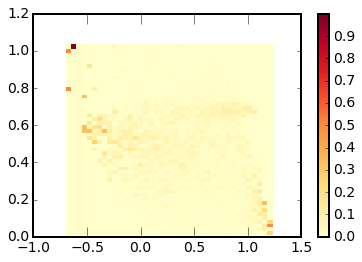

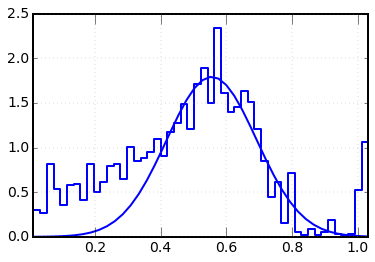

In [287]:
# Let's rotate this
rotation_angle = np.arctan(1.)

# Rotating the line
y_data = yvalues
x_data = xaxis_line
xpp = x_data*np.cos(rotation_angle) - y_data*np.sin(rotation_angle)
ypp = x_data*np.sin(rotation_angle) + y_data*np.cos(rotation_angle)
#plt.plot(x_data, y_data)
plt.plot(xpp,ypp)

# Rotating my function
plt.figure()
delta = (data['theta_f']-data['theta_i'])[sel]
new_x = data['theta_i'][sel]*np.cos(rotation_angle) - delta*np.sin(rotation_angle)
new_y = data['theta_i'][sel]*np.sin(rotation_angle) + delta*np.cos(rotation_angle)

xaxis = np.linspace(new_x.min(), new_x.max(), 41)
yaxis = np.linspace(new_y.min(), new_y.max(), 51)
n, x1, x2 = np.histogram2d(new_x, new_y, [xaxis, yaxis])
n2 = renormN(n,axis=1)
plt.pcolor(xaxis, yaxis, n2.T)
plt.colorbar()

plt.figure()
fit_y = np.sum(n2, axis=0)
jplot.unfilledBar(yaxis, fit_y)

fit_x = (yaxis[:-1]+yaxis[1:])/2.
fit_fcn = gaus
popt, pcov = optimize.curve_fit(gaus, fit_x[fit_x>0.35], 
                                fit_y[fit_x>0.35], p0=[100, 0.5, 0.3])

xtest = np.linspace(-1, 1.4, 100)
plt.plot(xtest, gaus(xtest, *popt))


print "The distribution has been rotated (delta Theta and theta in are the inputs)"
print "The rotation is given by"
print "new_x = data['theta_i'][sel]*np.cos(rotation_angle) - delta*np.sin(rotation_angle)"
print "new_y = data['theta_i'][sel]*np.sin(rotation_angle) + delta*np.cos(rotation_angle)"
print "The rotation angle is", rotation_angle
print "\nThe rotated distribution is a gaussian described by"
print "Mean", popt[1], "Sigma", popt[2]
print "Draw a random value from that distribution. That is new_y"
print "delta = ( new_y - theta_i*np.sin(rotation_angle) ) / np.cos(rotation_angle)"

Attempt of defining a gaussian as function of theta_i and not rotating
The gaussian structure is equally complicated


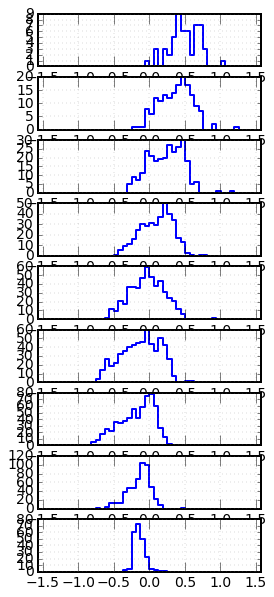

In [288]:
nbins= 9
fig = plt.figure(figsize=(4,10))
x2 = np.linspace(-np.pi/2, np.pi/2., 51)
theta_range = np.linspace(0, np.deg2rad(70), nbins+1)
for i in range(nbins):
    mybool = (data['theta_i'] > theta_range[i])*\
             (data['theta_i'] < theta_range[i+1])
 
    n, x2 = np.histogram(data['theta_f'][sel*mybool] - data['theta_i'][sel*mybool], 
                         x2)
    #np.sum(n)
    fig.add_subplot(nbins,1,i+1)
    
    jplot.unfilledBar(x2,n)

print 'Attempt of defining a gaussian as function of theta_i and not rotating'
print 'The gaussian structure is equally complicated'

### The phi angle for single reflections

It is very simple and specular-like. Need to shift by 180deg to get the gaussian
Paramters of the distribution
Gauss height 0.0299466743183 mean 3.19473273584 sigma 0.462176268564 constant 0.0144783826417
Fraction going to the constant 0.725903370027


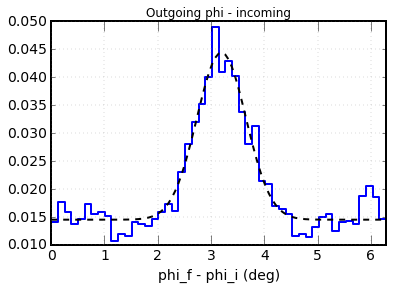

In [289]:
print 'It is very simple and specular-like. Need to shift by 180deg to get the gaussian'

shifted_phidiff = data['phidiff'] - np.pi
shifted_phidiff[shifted_phidiff<0] += 2*np.pi

x = np.linspace(0, np.pi*2, 51)
n, x= np.histogram(shifted_phidiff[sel],x)
n = n*1./np.sum(n)
jplot.unfilledBar(x,n)


xfit = edgesToMiddle(x)
newx = np.linspace(0, np.pi*2, 101)
fcn = lambda x, a, b, c, d: gaus(x,a,b, c) + d
popt, pcov = optimize.curve_fit(fcn, xfit, n, p0 = [0.1, np.pi, 1., 0.2])
curve = fcn(newx, *popt)
plt.plot(newx, curve, '--k')

#plt.xlabel('Incoming phi (deg)')
plt.xlabel('phi_f - phi_i (deg)')
#plt.colorbar()
plt.title('Outgoing phi - incoming')
print 'Paramters of the distribution'
print 'Gauss height', popt[0], 'mean', popt[1], 'sigma',popt[2], 'constant', popt[3]
print 'Fraction going to the constant', popt[3]*len(newx)/np.sum(curve)


### The deltaT for single reflections


Using deltaT vs theta


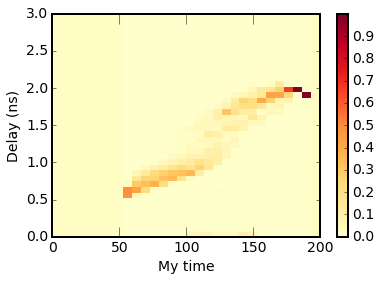

In [290]:
print 'Using deltaT vs theta'
xvalues = data['my_times'][sel]
yvalues = data['delta_t'][sel]
x1 = np.linspace(0, 200., 31)
x2 = np.linspace(0, 3., 41)
b,x,y = np.histogram2d(xvalues, yvalues, [x1,x2])
b = renormN(b,axis=1)
plt.pcolor(x1, x2, b.T)
plt.colorbar()
plt.ylabel('Delay (ns)')
plt.xlabel('My time')

# 

Using the correlation of delay and my calculated time
For a single reflection, simply take the calculated time/100.


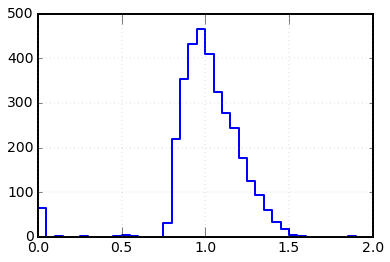

In [291]:
# c = 0.3 m/ns
# so to bring again to ns

tdiff = data['delta_t'][sel]/(data['my_times'][sel]/100.)
x1 = np.linspace(0, 2, 41)
b, x = np.histogram(tdiff, x1)
jplot.unfilledBar(x,b)

print 'Using the correlation of delay and my calculated time'
print 'For a single reflection, simply take the calculated time/100.'


### Theta angle for MULTIPLE reflections

In [105]:
print 'Selecting only the events that hit the PMT and leave after multiple reflections'
sel=( np.array([True]*len(data['y']))
     *pmt_hits
     *(data['nsteps'] > 1)
     #*(data['z'] > 0)
     #*(data['r']>0)
    )

Selecting only the events that hit the PMT and leave after multiple reflections


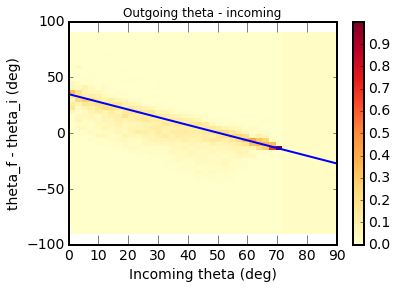

In [106]:
x1 = np.linspace(0, np.pi/2., 41)
x2 = np.linspace(-np.pi/2, np.pi/2., 51)
n, x1, x2 = np.histogram2d(data['theta_i'][sel], 
                           data['theta_f'][sel] - data['theta_i'][sel], 
                           [x1,x2])
n = renormN(n,axis=1)
plt.pcolor(np.rad2deg(x1),
           np.rad2deg(x2),
           n.T)
plt.xlabel('Incoming theta (deg)')
plt.ylabel('theta_f - theta_i (deg)')
plt.colorbar()
plt.title('Outgoing theta - incoming')
#plt.yticks(np.arange(-90, 90, 5.0))

xaxis_line = np.linspace(0, 90, 201)
yvalues = line_fcn(xaxis_line, -40./58, 35)
plt.plot(xaxis_line, yvalues)

The distribution has been rotated (delta Theta and theta in are the inputs)
The rotation is given by
new_x = data['theta_i'][sel]*np.cos(rotation_angle) - delta*np.sin(rotation_angle)
new_y = data['theta_i'][sel]*np.sin(rotation_angle) + delta*np.cos(rotation_angle)
The rotation angle is 0.603749333397

The rotated distribution is a gaussian described by
Mean 0.510609576505 Sigma 0.0838132207273
Draw a random value from that distribution. That is new_y
delta = ( new_y - theta_i*np.sin(rotation_angle) ) / np.cos(rotation_angle)


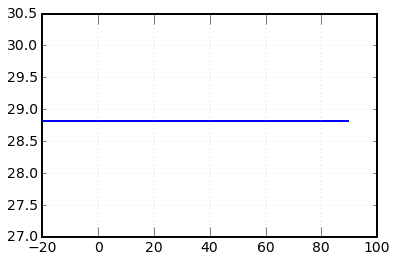

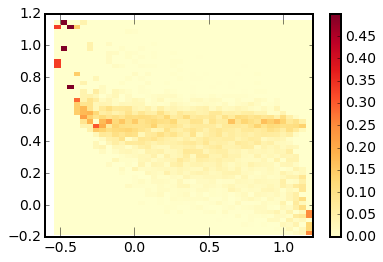

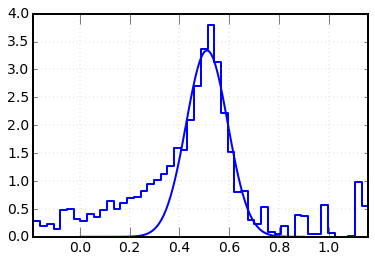

In [107]:
# Let's rotate this
rotation_angle = np.arctan(40./58.)

# Rotating the line
y_data = yvalues
x_data = xaxis_line
xpp = x_data*np.cos(rotation_angle) - y_data*np.sin(rotation_angle)
ypp = x_data*np.sin(rotation_angle) + y_data*np.cos(rotation_angle)
#plt.plot(x_data, y_data)
plt.plot(xpp,ypp)

# Rotating my function
plt.figure()
delta = (data['theta_f']-data['theta_i'])[sel]
new_x = data['theta_i'][sel]*np.cos(rotation_angle) - delta*np.sin(rotation_angle)
new_y = data['theta_i'][sel]*np.sin(rotation_angle) + delta*np.cos(rotation_angle)

xaxis = np.linspace(new_x.min(), new_x.max(), 41)
yaxis = np.linspace(new_y.min(), new_y.max(), 51)
n, x1, x2 = np.histogram2d(new_x, new_y, [xaxis, yaxis])
n2 = renormN(n,axis=1)
plt.pcolor(xaxis, yaxis, n2.T)
plt.colorbar()

plt.figure()
fit_y = np.sum(n2, axis=0)
jplot.unfilledBar(yaxis, fit_y)

fit_x = (yaxis[:-1]+yaxis[1:])/2.
fit_fcn = gaus
popt, pcov = optimize.curve_fit(gaus, fit_x[fit_x>0.35], 
                                fit_y[fit_x>0.35], p0=[100, 0.5, 0.3])

xtest = np.linspace(0, 0.9, 100)
plt.plot(xtest, gaus(xtest, *popt))


print "The distribution has been rotated (delta Theta and theta in are the inputs)"
print "The rotation is given by"
print "new_x = data['theta_i'][sel]*np.cos(rotation_angle) - delta*np.sin(rotation_angle)"
print "new_y = data['theta_i'][sel]*np.sin(rotation_angle) + delta*np.cos(rotation_angle)"
print "The rotation angle is", rotation_angle
print "\nThe rotated distribution is a gaussian described by"
print "Mean", popt[1], "Sigma", popt[2]
print "Draw a random value from that distribution. That is new_y"
print "delta = ( new_y - theta_i*np.sin(rotation_angle) ) / np.cos(rotation_angle)"

### Phi angle for MULTIPLE reflections

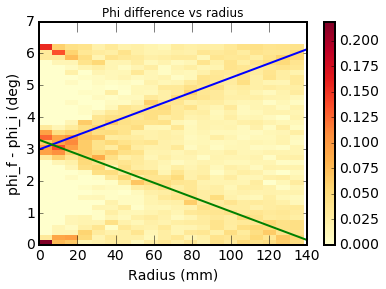

In [108]:
x1 = np.linspace(0, 138., 21)
x2 = np.linspace(0, np.pi*2, 41)
n, x1, x2 = np.histogram2d(data['r'][sel], 
                           data['phidiff'][sel], 
                           [x1,x2])
n = renormN(n,axis=1)
plt.pcolor(x1,
           x2,
           n.T)
plt.xlabel('Radius (mm)')
plt.ylabel('phi_f - phi_i (deg)')
plt.colorbar()
plt.title('Phi difference vs radius')

xaxis_line = np.linspace(0, 140, 201)
yvalues = line_fcn(xaxis_line, np.pi/140, np.pi-0.15)
yvalues2 = line_fcn(xaxis_line, -np.pi/140, np.pi+0.15)

plt.plot(xaxis_line, yvalues)
plt.plot(xaxis_line, yvalues2)

Simply get the gaussian from the beginning. Shift the other values
[ 10.28978733   3.1155743    0.28817758]
[ 19.54590592   3.15735971   0.51702729]
[ 14.5300829    3.11680387   1.85197935]
[ 15.67091492   2.90515503   2.75591096  -9.45964933   1.35560035
   0.21137409]
[ 18.97692631   4.64703202   0.85848237  18.17056003   1.42062296
   1.48689215]
[ 21.43202099   5.08791205   1.01497259  21.04825336   1.07513108
   1.10172376]
[ 22.96636928   5.83631127   1.1845416   31.87804303  -1.48443401
   2.66181565]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

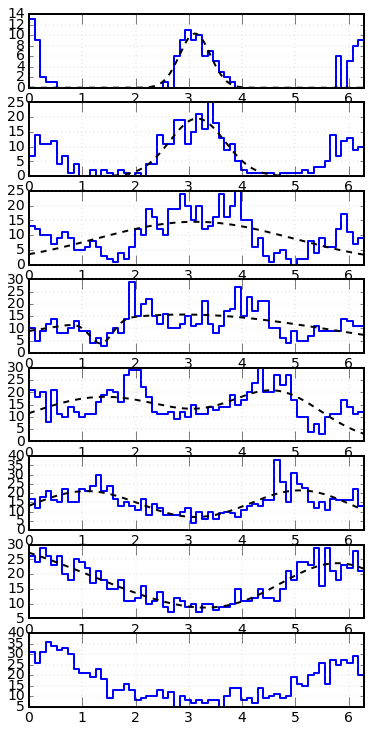

In [109]:
print 'Simply get the gaussian from the beginning. Shift the other values'
nbins= 9
fig = plt.figure(figsize=(6,14))
x2 = np.linspace(0, np.pi*2., 61)
xtest = np.linspace(0, np.pi*2, 201)

xfit = edgesToMiddle(x2)

means = np.zeros([nbins,2])
stds  = np.zeros([nbins,2])

radius_range = np.linspace(0, 140, nbins+1)
radius_fit   = edgesToMiddle(radius_range)
for i in range(nbins):
    mybool = (data['r'] > radius_range[i])*\
             (data['r'] < radius_range[i+1])
 
    n, x2 = np.histogram(data['phidiff'][sel*mybool], 
                         x2)
    #np.sum(n)
    fig.add_subplot(nbins,1,i+1)
    
    jplot.unfilledBar(x2,n)
    
    p0a = [30, np.pi+i/2., 1.]
    p0b = [20, np.pi-i/2., 1.]
    
    if i <3:
        popt, pcov = optimize.curve_fit(gaus, xfit, n, p0 = p0a)
        plt.plot(xtest, gaus(xtest, *popt), '--k')
        means[i,:] = [popt[1], popt[1]]
        stds[i,:]  = [popt[2], popt[2]]
    else:
        popt, pcov = optimize.curve_fit(two_gaus, xfit, n, p0 = p0a+p0b)
        plt.plot(xtest, two_gaus(xtest, *popt), '--k')
        means[i,:] = [popt[1], popt[1+3]-0.1]
        stds[i,:]  = [popt[2], popt[2+3]+0.1]

    print popt

print 'Attempt of defining a gaussian as function of theta_i and not rotating'
print 'The gaussian structure is equally complicated'

Do not use the last point because the fit is missing.
Function for the mean  
0.01956 x + 2.956
Function for the std  
0.002083 x + 0.9323


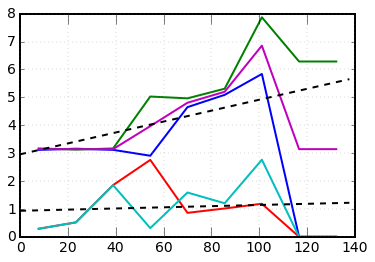

In [110]:
plt.plot(radius_fit, means[:,0])
plt.plot(radius_fit, 2*np.pi-means[:,1])
plt.plot(radius_fit, stds)

the_mean = ((means[:,0] + 2*np.pi-means[:,1])/2.)
plt.plot(radius_fit, the_mean)

print 'Do not use the last point because the fit is missing.'
mean_coeffs = np.polyfit(radius_fit[:-1], the_mean[:-1], deg=1)
std_coeffs  = np.polyfit(radius_fit[:-1], np.average(stds[:-1,:],axis=1), deg=1)

mean_fcn = np.poly1d(mean_coeffs)
std_fcn  = np.poly1d(std_coeffs)

xtest = np.linspace(0, greydisc_radius, 201)
plt.plot(xtest, mean_fcn(xtest), '--k')
plt.plot(xtest, std_fcn(xtest), '--k')

print 'Function for the mean', mean_fcn
print 'Function for the std', std_fcn

Lets rotate this thing


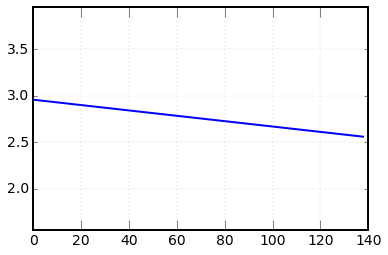

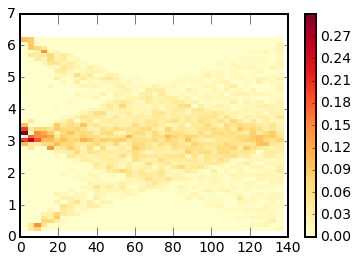

In [111]:
print 'Lets rotate this thing'
# Let's rotate this
rotation_angle = np.arctan(-0.02244)

# Rotating the line
x_data = xtest
y_data = mean_fcn(xtest)
xpp = x_data*np.cos(rotation_angle) - y_data*np.sin(rotation_angle)
ypp = x_data*np.sin(rotation_angle) + y_data*np.cos(rotation_angle)
#plt.plot(x_data, y_data)
plt.plot(xpp,ypp)
plt.ylim(ypp.min()-1., ypp.max()+1)

# Rotating my function
plt.figure()


# Splitting up and down here
up = data['phidiff'] > np.pi
down = data['phidiff'] < np.pi


new_x = data['r'][sel*up]*np.cos(rotation_angle) - data['phidiff'][sel*up]*np.sin(rotation_angle)
new_y = data['r'][sel*up]*np.sin(rotation_angle) + data['phidiff'][sel*up]*np.cos(rotation_angle)

new_xd = data['r'][sel*down]*np.cos(-rotation_angle) - data['phidiff'][sel*down]*np.sin(-rotation_angle)
new_yd = data['r'][sel*down]*np.sin(-rotation_angle) + data['phidiff'][sel*down]*np.cos(-rotation_angle)

all_x = np.concatenate((new_x, new_xd))
all_y = np.concatenate((new_y, new_yd))

xaxis = np.linspace(new_x.min(), new_x.max(), 41)
yaxis = np.linspace(new_y.min(), new_y.max(), 51)
n, x1, x2 = np.histogram2d(all_x, all_y, [xaxis, yaxis])
n2 = renormN(n,axis=1)
plt.pcolor(xaxis, yaxis, n2.T)
plt.colorbar()


Simply get the gaussian from the beginning. Shift the other values
[ 14.55318937   3.18654785   0.20592174]
[ 28.66303207   3.11918444   0.35652053]
[ 26.98410849   3.11166927   0.83004283]
[ 31.10834423   3.09644927   0.98014201]
[ 41.55323497   3.05688114   0.97580985]
[ 45.35563771   3.08475918   0.85821935]
[ 47.13113698   3.12298241   0.85537267]
[ 55.7829173    3.16157686   0.58976702]
[ 37.36568354   3.14009426   0.62772122]
Attempt of defining a gaussian as function of theta_i and not rotating
The gaussian structure is equally complicated


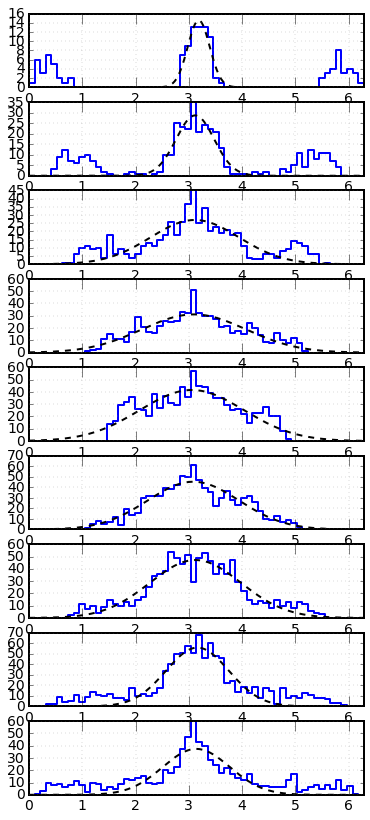

In [112]:
print 'Simply get the gaussian from the beginning. Shift the other values'
nbins= 9
fig = plt.figure(figsize=(6,14))
x2 = np.linspace(0, np.pi*2., 61)
xtest = np.linspace(0, np.pi*2, 201)

xfit = edgesToMiddle(x2)

means = np.zeros(nbins)
stds  = np.zeros(nbins)

radius_range = np.linspace(0, 140, nbins+1)
radius_fit   = edgesToMiddle(radius_range)
for i in range(nbins):
    mybool = (all_x > radius_range[i])*\
             (all_x < radius_range[i+1])
 
    n, x2 = np.histogram(all_y[mybool], 
                         x2)
    #np.sum(n)
    fig.add_subplot(nbins,1,i+1)
    
    jplot.unfilledBar(x2,n)
    
    p0a = [30, np.pi+i/2., 1.]
    p0b = [20, np.pi-i/2., 1.]
    
    popt, pcov = optimize.curve_fit(gaus, xfit, n, p0 = p0a)
    plt.plot(xtest, gaus(xtest, *popt), '--k')
    means[i] = popt[1]
    stds[i]  = popt[2]


    print popt

print 'Attempt of defining a gaussian as function of theta_i and not rotating'
print 'The gaussian structure is equally complicated'

Function  
0.002481 x + 0.524


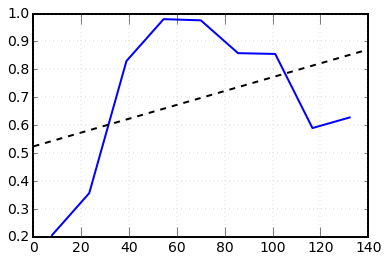

In [113]:
plt.plot(radius_fit, np.abs(stds))
xtest = np.linspace(0, greydisc_radius, 201)

fcn = np.poly1d(np.polyfit(radius_fit, np.abs(stds), deg=1))
plt.plot(xtest, fcn(xtest), '--k')
print 'Function', fcn

In [114]:
print 'Steps\n'

print "Get the radius R - so close to actual radius, no need to rotate"
print 'Determine the STD DEV of the gaussian to use with 0.00897*r + 0.1378'
print "Evaluate a random gauss, multiply times STD DEV"
print "Draw another random number to determine rotation up or down (50/50)"
print "Get the phidiff mean by:"
print "(+/-)0.02244 *r + 2.777"
print "Sum that number to the random number drawn before"
print "Verify you can rotate by so much"

Steps

Get the radius R - so close to actual radius, no need to rotate
Determine the STD DEV of the gaussian to use with 0.00897*r + 0.1378
Evaluate a random gauss, multiply times STD DEV
Draw another random number to determine rotation up or down (50/50)
Get the phidiff mean by:
(+/-)0.02244 *r + 2.777
Sum that number to the random number drawn before
Verify you can rotate by so much


### DeltaT for multiple reflections

Using deltaT vs theta


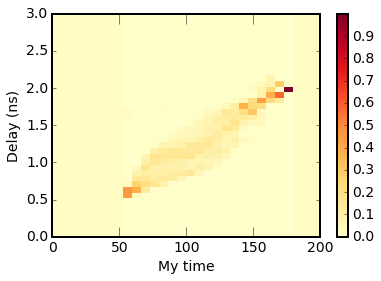

In [115]:
print 'Using deltaT vs theta'
xvalues = data['my_times'][sel]
yvalues = data['delta_t'][sel]
x1 = np.linspace(0, 200., 31)
x2 = np.linspace(0, 3., 41)
b,x,y = np.histogram2d(xvalues, yvalues, [x1,x2])
b = renormN(b,axis=1)
plt.pcolor(x1, x2, b.T)
plt.colorbar()
plt.ylabel('Delay (ns)')
plt.xlabel('My time')


In [ ]:
# Similar as before, but the slope is no longer 100. It's more like 180/2.

Using the correlation of delay and my calculated time
For a single reflection, simply take the calculated time/90.


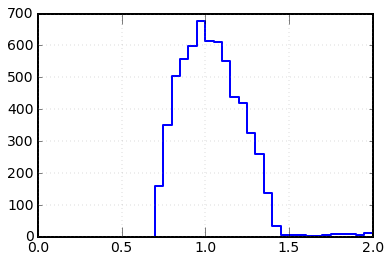

In [125]:
# c = 0.3 m/ns
# so to bring again to ns

tdiff = data['delta_t'][sel]/(data['my_times'][sel]/90.)
x1 = np.linspace(0, 2., 41)
b, x = np.histogram(tdiff, x1)
jplot.unfilledBar(x,b)

print 'Using the correlation of delay and my calculated time'
print 'For a single reflection, simply take the calculated time/90.'


# Hit the CONCENTRATOR first

In [126]:
print 'Selecting only the events that hit the CONCENTRATOR'
sel=( np.array([True]*len(data['y']))
     *conc_hits
     
    )
print 'Events ', np.sum(sel)


Selecting only the events that hit the CONCENTRATOR
Events  61557


Define single/multiple reflections
This function is enough. Draw random number, eval the function at theta_i
If random is larger than fcn value, single rejection
        5        4         3         2
-1.547 x + 4.62 x - 5.108 x + 2.455 x - 0.4318 x + 0.8755


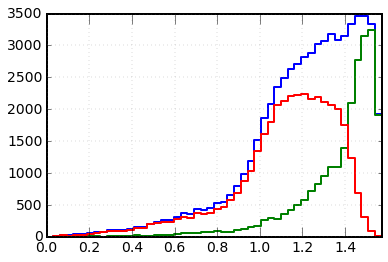

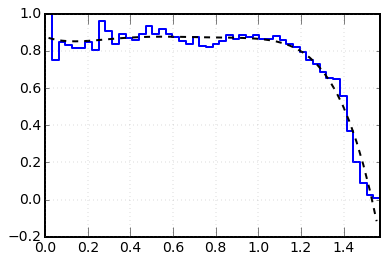

In [127]:
print 'Define single/multiple reflections'
xaxis = np.linspace(0, np.pi/2., 51)
yvalues = data['theta_i'][sel]
n, x = np.histogram(yvalues, xaxis)
jplot.unfilledBar(x,n)
yvalues = data['theta_i'][sel*(data['nsteps']<1.5)]
ns, x = np.histogram(yvalues, xaxis)
jplot.unfilledBar(x,ns, color = 'green')
yvalues = data['theta_i'][sel*(data['nsteps']>1.5)]
nm, x = np.histogram(yvalues, xaxis)
jplot.unfilledBar(x,nm, color = 'red')


xfit = edgesToMiddle(xaxis)
fcn  = np.poly1d(np.polyfit(xfit, nm*1./n, deg=5))

plt.figure()
jplot.unfilledBar(x, nm*1./n)
plt.plot(xfit, fcn(xfit), '--k')

print 'This function is enough. Draw random number, eval the function at theta_i'
print 'If random is larger than fcn value, single rejection'
print fcn

## Theta for either SINGLE or MULTIPLE is specular<br> For multiple it has a width. For single is perfectly specular.

[  3.35712457e+03  -2.49017742e-02   8.45685378e-02]
[  6.82579418e+03  -4.76071296e-03   6.42887180e-02]
Using the same standard deviation for both of 0.08 radians


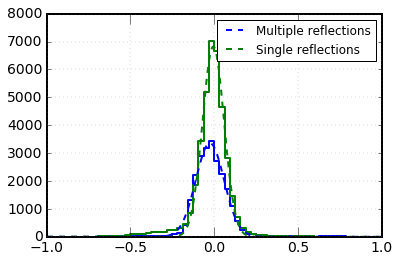

In [128]:
xaxis = np.linspace(-np.pi/2. , np.pi/2, 101)
ydata = data['theta_f'] - data['theta_i']
single = data['nsteps'] < 1.5
multiple = data['nsteps'] > 1.5

xfit = edgesToMiddle(xaxis)
xtst = np.linspace(xaxis.min(), xaxis.max(), 500)

n, x = np.histogram(ydata[sel*single], xaxis)
jplot.unfilledBar(x,n)

n2, x = np.histogram(ydata[sel*multiple], xaxis)
jplot.unfilledBar(x, n2, color = 'green')

popt, pcov = optimize.curve_fit(gaus, xfit, n, p0 = [8000, 0., 0.3])
popt2, pcov = optimize.curve_fit(gaus, xfit, n2, p0 = [3000, 0., 0.3])

plt.plot(xtst, gaus(xtst, *popt), '--b', label='Multiple reflections')
plt.plot(xtst, gaus(xtst, *popt2), '--g', label='Single reflections')
plt.xlim(-1,1)
print popt
print popt2
plt.legend(loc=0)
print 'Using the same standard deviation for both of 0.08 radians'

## PHI for single reflections

In [333]:
print 'Selecting only the events that hit the CONCENTRATOR'
sel=( np.array([True]*len(data['y']))
     *conc_hits
     *(data['nsteps'] < 1.5)
     
    )
print 'Events ', np.sum(sel)


Selecting only the events that hit the CONCENTRATOR
Events  23360


[ 58.48952119   3.15403073   0.27557623]
[ 148.52898184    3.143143      0.33035776]
[ 137.91664454    2.87686981    0.32225944  131.14030881    3.49040083
    0.27832892]
[ 163.80836689    2.73981035    0.34631717  146.59430803    3.59806055
    0.31131385]
[ 87.38365279   3.15554203   0.78508098  71.44018201   3.14310079
   0.78517402]
[ 138.3093154     2.54871897    0.51921417  124.70971824    3.8029095
    0.49617347]
[ 130.99469539    2.37489005    0.54077334  132.2110637     3.86676422
    0.5693919 ]
[ 115.62827539    2.33375349    0.6414343   110.6025085     4.00114016
    0.66399934]
[ 86.77705609   2.19976293   0.6797089   95.77778826   3.87929341
   0.68990149]
Attempt of defining a gaussian as function of theta_i and not rotating
The gaussian structure is equally complicated


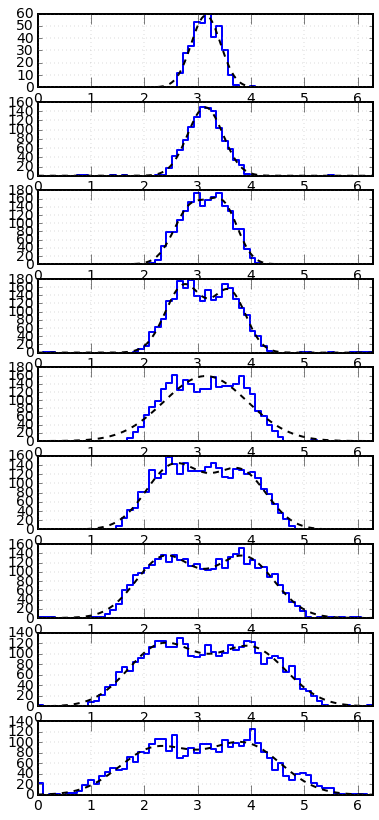

In [334]:
nbins= 9
fig = plt.figure(figsize=(6,14))
x2 = np.linspace(0, np.pi*2., 61)
xtest = np.linspace(0, np.pi*2, 201)

xfit = edgesToMiddle(x2)

means = np.zeros([nbins,2])
stds  = np.zeros([nbins,2])

radius_range = np.linspace(0, 130., nbins+1)
radius_fit   = edgesToMiddle(radius_range)
for i in range(nbins):
    mybool = (data['r'] > radius_range[i])*\
             (data['r'] < radius_range[i+1])
 
    n, x2 = np.histogram(data['phidiff'][sel*mybool], 
                         x2)
    #np.sum(n)
    fig.add_subplot(nbins,1,i+1)
    
    jplot.unfilledBar(x2,n)
    
    p0a = [30, np.pi+i/5., 1.]
    p0b = [20, np.pi-i/5., 1.]
    
    if i <2:
        popt, pcov = optimize.curve_fit(gaus, xfit, n, p0 = p0a)
        plt.plot(xtest, gaus(xtest, *popt), '--k')
        means[i,:] = [popt[1], popt[1]]
        stds[i,:]  = [popt[2], popt[2]]
    else:
        popt, pcov = optimize.curve_fit(two_gaus, xfit, n, p0 = p0a+p0b)
        plt.plot(xtest, two_gaus(xtest, *popt), '--k')
        means[i,:] = [popt[1], popt[1+3]]
        stds[i,:]  = [popt[2], popt[2+3]]

    print popt
    
stds = np.abs(stds)

print 'Attempt of defining a gaussian as function of theta_i and not rotating'
print 'The gaussian structure is equally complicated'

Do not use the last point because the fit is missing.
Function for the mean  
-0.008317 x + 3.255
Function for the std  
0.003991 x + 0.2364


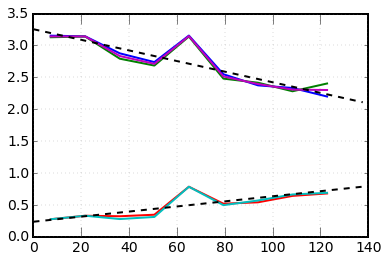

In [335]:
plt.plot(radius_fit, means[:,0])
plt.plot(radius_fit, 2*np.pi-means[:,1])
plt.plot(radius_fit, stds)

the_mean = ((means[:,0] + 2*np.pi-means[:,1])/2.)
plt.plot(radius_fit, the_mean)

print 'Do not use the last point because the fit is missing.'
mean_coeffs = np.polyfit(radius_fit[:-1], the_mean[:-1], deg=1)
std_coeffs  = np.polyfit(radius_fit[:-1], np.average(stds[:-1,:],axis=1), deg=1)

mean_fcn = np.poly1d(mean_coeffs)
std_fcn  = np.poly1d(std_coeffs)

xtest = np.linspace(0, greydisc_radius, 201)
plt.plot(xtest, mean_fcn(xtest), '--k')
plt.plot(xtest, std_fcn(xtest), '--k')

print 'Function for the mean', mean_fcn
print 'Function for the std', std_fcn

Lets rotate this thing


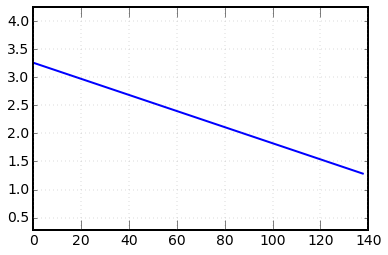

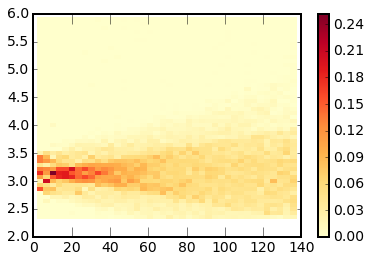

In [336]:
print 'Lets rotate this thing'
# Let's rotate this
rotation_angle = np.arctan(0.005997*-1.)

# Rotating the line
x_data = xtest
y_data = mean_fcn(xtest)
xpp = x_data*np.cos(rotation_angle) - y_data*np.sin(rotation_angle)
ypp = x_data*np.sin(rotation_angle) + y_data*np.cos(rotation_angle)
#plt.plot(x_data, y_data)
plt.plot(xpp,ypp)
plt.ylim(ypp.min()-1., ypp.max()+1)

# Rotating my function
plt.figure()


# Splitting up and down here
up = data['phidiff'] > np.pi
down = data['phidiff'] < np.pi


new_x = data['r'][sel*up]*np.cos(rotation_angle) - data['phidiff'][sel*up]*np.sin(rotation_angle)
new_y = data['r'][sel*up]*np.sin(rotation_angle) + data['phidiff'][sel*up]*np.cos(rotation_angle)

new_xd = data['r'][sel*down]*np.cos(-rotation_angle) - data['phidiff'][sel*down]*np.sin(-rotation_angle)
new_yd = data['r'][sel*down]*np.sin(-rotation_angle) + data['phidiff'][sel*down]*np.cos(-rotation_angle)

all_x = np.concatenate((new_x, new_xd))
all_y = np.concatenate((new_y, new_yd))

xaxis = np.linspace(new_x.min(), new_x.max(), 41)
yaxis = np.linspace(new_y.min(), new_y.max(), 51)
n, x1, x2 = np.histogram2d(all_x, all_y, [xaxis, yaxis])
n2 = renormN(n,axis=1)
plt.pcolor(xaxis, yaxis, n2.T)
plt.colorbar()


Simply get the gaussian from the beginning. Shift the other values
[ 96.9679501    3.13576468   0.18345739]
[  2.93545874e+02   3.14460999e+00   1.75860840e-01]
[  3.67240583e+02   3.14024200e+00   2.33706295e-01]
[  3.56782580e+02   3.13892115e+00   3.24448120e-01]
[ 322.34294576    3.1346615     0.41665509]
[ 304.05814837    3.1422816     0.48678912]
[ 284.14583489    3.13281338    0.56101985]
[ 249.01985505    3.12631569    0.59952538]
[ 166.07540467    3.12739256    0.55193595]
Attempt of defining a gaussian as function of theta_i and not rotating
The gaussian structure is equally complicated


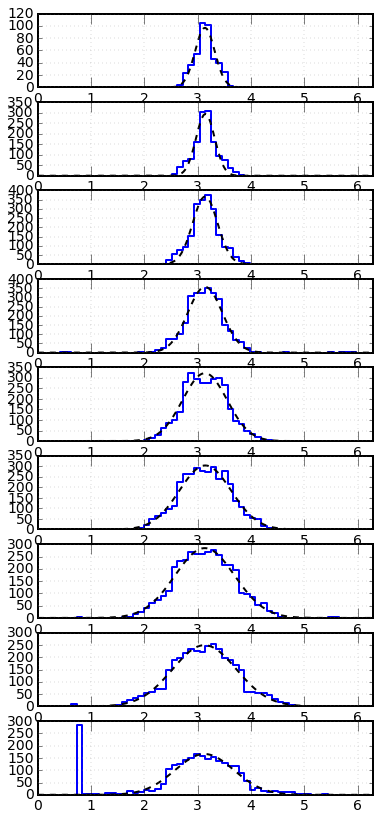

In [337]:
print 'Simply get the gaussian from the beginning. Shift the other values'
nbins= 9
fig = plt.figure(figsize=(6,14))
x2 = np.linspace(0, np.pi*2., 61)
xtest = np.linspace(0, np.pi*2, 201)

xfit = edgesToMiddle(x2)

means = np.zeros(nbins)
stds  = np.zeros(nbins)

radius_range = np.linspace(0, 140, nbins+1)
radius_fit   = edgesToMiddle(radius_range)
for i in range(nbins):
    mybool = (all_x > radius_range[i])*\
             (all_x < radius_range[i+1])
 
    n, x2 = np.histogram(all_y[mybool], 
                         x2)
    #np.sum(n)
    fig.add_subplot(nbins,1,i+1)
    
    jplot.unfilledBar(x2,n)
    
    p0a = [30, np.pi+i/2., 1.]
    p0b = [20, np.pi-i/2., 1.]
    
    popt, pcov = optimize.curve_fit(gaus, xfit, n, p0 = p0a)
    plt.plot(xtest, gaus(xtest, *popt), '--k')
    means[i] = popt[1]
    stds[i]  = popt[2]


    print popt

print 'Attempt of defining a gaussian as function of theta_i and not rotating'
print 'The gaussian structure is equally complicated'

Function  
0.003816 x + 0.1255


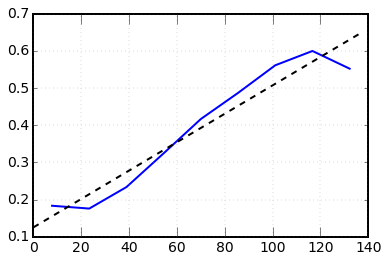

In [338]:
plt.plot(radius_fit, np.abs(stds))
xtest = np.linspace(0, greydisc_radius, 201)

fcn = np.poly1d(np.polyfit(radius_fit, np.abs(stds), deg=1))
plt.plot(xtest, fcn(xtest), '--k')
print 'Function', fcn

### DeltaT for single reflections

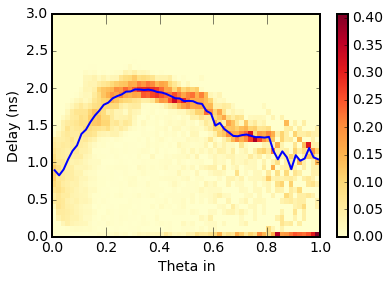

In [339]:
xvalues = np.cos(data['theta_i'][sel])
yvalues = data['delta_t'][sel]
x1 = np.linspace(0, 1., 61)
x2 = np.linspace(0, 3., 41)
b,x,y = np.histogram2d(xvalues, yvalues, [x1,x2])
b = renormN(b,axis=1)
plt.pcolor(x1, x2, b.T)
plt.colorbar()
plt.ylabel('Delay (ns)')
plt.xlabel('Theta in')

# the means look bad
ycenters = (x2[1:] + x2[:-1])/2.
xcenters = (x1[1:] + x1[:-1])/2.
means = np.zeros(b.shape[0])
for xbin in range(b.shape[0]):
    means[xbin] = np.sum(b[xbin,:] * ycenters[:])/np.sum(b[xbin,:])
#plt.plot(xcenters, means)

medians = np.zeros_like(means)
for xbin in range(b.shape[0]):
    thebool = (xvalues>x1[xbin])*(xvalues<x1[xbin+1])*(yvalues>0.3)
    
    medians[xbin] = np.median(yvalues[thebool])
#print xcenters.shape, medians.shape
plt.plot(xcenters, medians)

1.2313323394792306

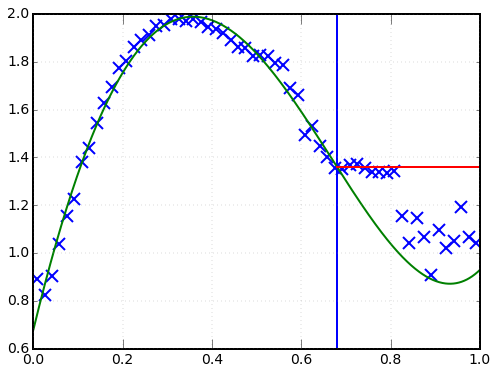

In [340]:
# Let's try to parameterize that line
plt.figure(figsize=(8,6))

maxfit = 0.68

plt.axvline(x=maxfit, ymin=0, ymax=2)


xtest = np.linspace(0, 1, 1000.)
indexf = np.where(xcenters>maxfit)[0][0]-1

myfit = np.poly1d(np.polyfit(xcenters[:indexf], medians[:indexf], deg = 4))
plt.plot(xcenters, medians, 'x', markersize=12)
plt.plot(xtest, myfit(xtest))
plt.plot([maxfit, 1], [myfit(maxfit)]*2)
myfit(0.725)

1.3477578717932501

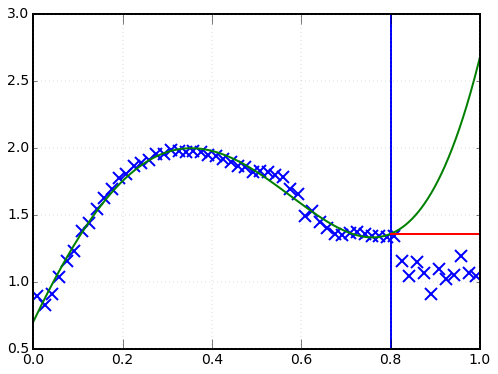

In [341]:
# Let's try to parameterize that line
plt.figure(figsize=(8,6))

maxfit = 0.8

plt.axvline(x=maxfit, ymin=0, ymax=2)


xtest = np.linspace(0, 1, 1000.)
indexf = np.where(xcenters>maxfit)[0][0]-1

myfit = np.poly1d(np.polyfit(xcenters[:indexf], medians[:indexf], deg = 4))
plt.plot(xcenters, medians, 'x', markersize=12)
plt.plot(xtest, myfit(xtest))
plt.plot([maxfit, 1], [myfit(maxfit)]*2)
myfit(0.725)

In [302]:
print myfit

       4        3         2
15.12 x - 13.8 x - 6.292 x + 6.94 x + 0.7043


In [342]:
print myfit(maxfit)

1.35805997697


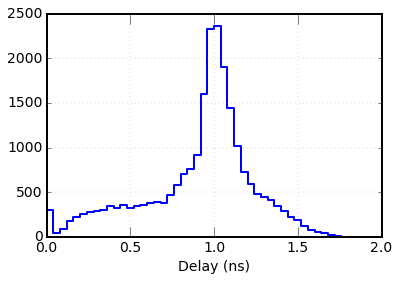

In [303]:
newtdelay = data['delta_t'][sel]/myfit(np.cos(data['theta_i'][sel]))
newtdelay[np.cos(data['theta_i'][sel])>0.8] = data['delta_t'][sel][np.cos(data['theta_i'][sel])>0.8]/myfit(0.8)

yvalues = newtdelay
x2 = np.linspace(0, 2., 51)
b,x = np.histogram(yvalues, x2)
jplot.unfilledBar(x,b)
plt.xlabel('Delay (ns)')


## PHI for MULTIPLE reflections

In [343]:
print 'Selecting only the events that hit the CONCENTRATOR'
sel=( np.array([True]*len(data['y']))
     *conc_hits
     *(data['nsteps'] > 1.5)
     
    )
print 'Events ', np.sum(sel)


Selecting only the events that hit the CONCENTRATOR
Events  38197


Attempt of defining a gaussian as function of theta_i and not rotating
The gaussian structure is equally complicated


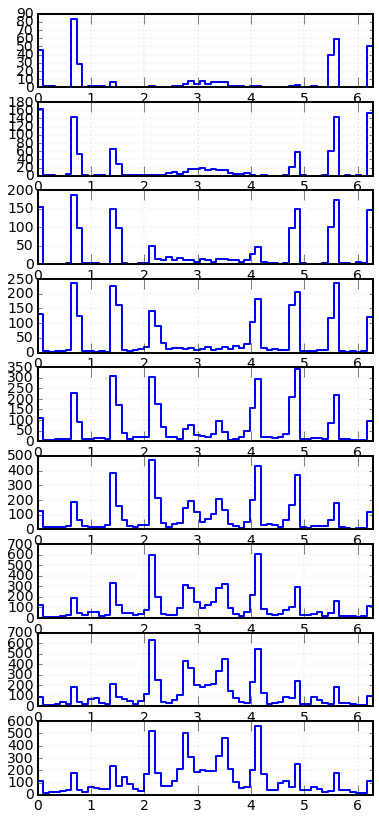

In [344]:
nbins= 9
fig = plt.figure(figsize=(6,14))
x2 = np.linspace(0, np.pi*2., 61)
xtest = np.linspace(0, np.pi*2, 201)

xfit = edgesToMiddle(x2)

means = np.zeros([nbins,2])
stds  = np.zeros([nbins,2])

radius_range = np.linspace(0, 130., nbins+1)
radius_fit   = edgesToMiddle(radius_range)
for i in range(nbins):
    mybool = (data['r'] > radius_range[i])*\
             (data['r'] < radius_range[i+1])
 
    n, x2 = np.histogram(data['phidiff'][sel*mybool], 
                         x2)
    #np.sum(n)
    fig.add_subplot(nbins,1,i+1)
    
    jplot.unfilledBar(x2,n)
    


print 'Attempt of defining a gaussian as function of theta_i and not rotating'
print 'The gaussian structure is equally complicated'

In [345]:
print 'For now I will just put 9 peaks for this function. No more.'

For now I will just put 9 peaks for this function. No more.


In [346]:
np.rad2deg(x2)

array([   0.,    6.,   12.,   18.,   24.,   30.,   36.,   42.,   48.,
         54.,   60.,   66.,   72.,   78.,   84.,   90.,   96.,  102.,
        108.,  114.,  120.,  126.,  132.,  138.,  144.,  150.,  156.,
        162.,  168.,  174.,  180.,  186.,  192.,  198.,  204.,  210.,
        216.,  222.,  228.,  234.,  240.,  246.,  252.,  258.,  264.,
        270.,  276.,  282.,  288.,  294.,  300.,  306.,  312.,  318.,
        324.,  330.,  336.,  342.,  348.,  354.,  360.])

40 (400,)


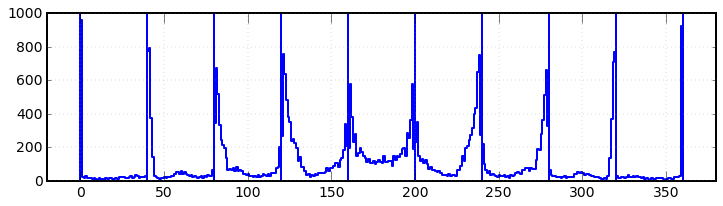

In [347]:
nbins= 9
fig = plt.figure(figsize=(12,3))
#x2 = np.arange(np.deg2rad(-20), np.pi*2.+np.deg2rad(20),np.deg2rad(1))
x2 = np.linspace(np.deg2rad(-20), np.pi*2.+np.deg2rad(20), 401)
xtest = np.linspace(0, np.pi*2, 201)

#print np.sum(x2<np.deg2rad(20.)), x2.shape
rollover = np.sum(x2<np.deg2rad(20.))-1
#print rollover, x2.shape

xfit = edgesToMiddle(x2)

means = np.zeros([nbins,2])
stds  = np.zeros([nbins,2])

radius_range = np.linspace(0, 130., nbins+1)
radius_fit   = edgesToMiddle(radius_range)
n, x2 = np.histogram(data['phidiff'][sel], 
                         x2)
print rollover, n.shape

for i in range(10):
    plt.axvline(i*40., ymax=5000.)

    #np.sum(n)
#fig.add_subplot(nbins,1,i+1)
    
jplot.unfilledBar(np.rad2deg(x2),n)


(10, 40)
[  2.78066170e+03   3.02368993e-04   4.78162912e-02   4.77531371e+02]
Attempt of defining a gaussian as function of theta_i and not rotating
The gaussian structure is equally complicated


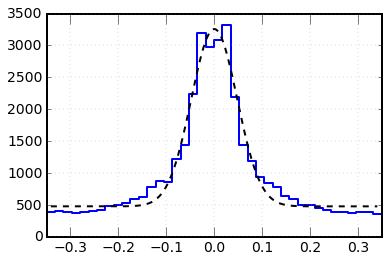

In [348]:

plt.figure()
nfixed = n.reshape([n.size/rollover,rollover])
print nfixed.shape

newy = np.sum(nfixed,axis=0)
newx = x2[:rollover+1]

jplot.unfilledBar(newx, newy)


xfit = edgesToMiddle(newx)

fcn = lambda x, a, b, c, d: gaus(x,a,b, c) + d

popt, pcov = optimize.curve_fit(fcn, xfit, newy, p0=[8000,0., 0.2, 1000.])
xtest = np.linspace(xfit.min(), xfit.max(), 1000.)
plt.plot(xtest, fcn(xtest, *popt), '--k')

print popt
print 'Attempt of defining a gaussian as function of theta_i and not rotating'
print 'The gaussian structure is equally complicated'

In [349]:
np.rad2deg(0.05)

2.8647889756541165

### DeltaT for multiple reflections 

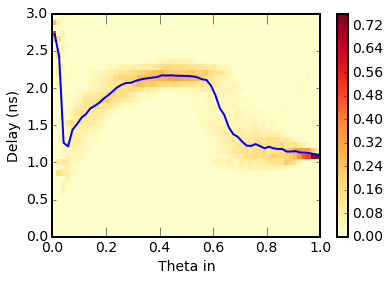

In [350]:
xvalues = np.cos(data['theta_i'][sel])
yvalues = data['delta_t'][sel]
x1 = np.linspace(0, 1., 61)
x2 = np.linspace(0, 3., 41)
b,x,y = np.histogram2d(xvalues, yvalues, [x1,x2])
b = renormN(b,axis=1)
plt.pcolor(x1, x2, b.T)
plt.colorbar()
plt.ylabel('Delay (ns)')
plt.xlabel('Theta in')

# the means look bad
ycenters = (x2[1:] + x2[:-1])/2.
xcenters = (x1[1:] + x1[:-1])/2.
means = np.zeros(b.shape[0])
for xbin in range(b.shape[0]):
    means[xbin] = np.sum(b[xbin,:] * ycenters[:])/np.sum(b[xbin,:])
#plt.plot(xcenters, means)

medians = np.zeros_like(means)
for xbin in range(b.shape[0]):
    thebool = (xvalues>x1[xbin])*(xvalues<x1[xbin+1])*(yvalues>0.3)
    
    medians[xbin] = np.median(yvalues[thebool])
#print xcenters.shape, medians.shape
plt.plot(xcenters, medians)

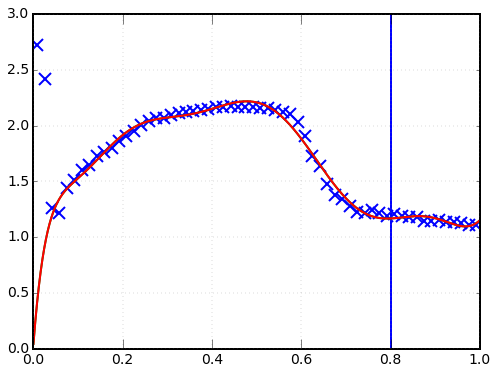

In [365]:
# Let's try to parameterize that line
plt.figure(figsize=(8,6))


plt.axvline(x=maxfit, ymin=0, ymax=2)


xtest = np.linspace(0, 1, 1000.)

myfit = np.poly1d(np.polyfit(xcenters[2:], medians[2:], deg = 10))
plt.plot(xcenters, medians, 'x', markersize=12)
plt.plot(xtest, myfit(xtest))
plt.plot(xtest, myfit2(xtest))
#plt.plot([maxfit, 1], [myfit(maxfit)]*2)
#myfit(0.725)

0.229308007232


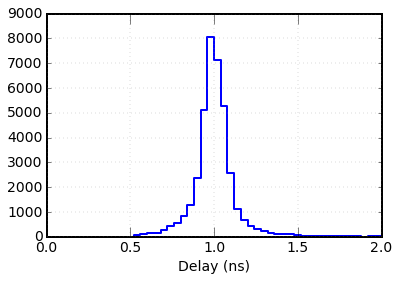

In [325]:
newtdelay = data['delta_t'][sel]/myfit(np.cos(data['theta_i'][sel]))

yvalues = newtdelay
x2 = np.linspace(0, 2., 51)
b,x = np.histogram(yvalues, x2)
jplot.unfilledBar(x,b)
plt.xlabel('Delay (ns)')
print newtdelay.std()

In [326]:
print myfit

            10             9             8             7             6
-1.936e+04 x  + 1.068e+05 x - 2.507e+05 x + 3.268e+05 x - 2.591e+05 x
              5             4        3         2
 + 1.289e+05 x - 4.016e+04 x + 7611 x - 834.2 x + 51.72 x + 0.04368


In [363]:
print ["%.4f" % i for i in myfit.coeffs]

['-19356.9021', '106776.7463', '-250656.8864', '326762.7911', '-259110.3902', '128914.3325', '-40156.7876', '7610.7330', '-834.2479', '51.7195', '0.0437']


In [332]:
myfit.coeffs

array([ -1.93569021e+04,   1.06776746e+05,  -2.50656886e+05,
         3.26762791e+05,  -2.59110390e+05,   1.28914332e+05,
        -4.01567876e+04,   7.61073300e+03,  -8.34247907e+02,
         5.17194675e+01,   4.36766447e-02])

In [357]:
myfit(0.644251)
#myfit(0.352358)

15.96738117362211

In [364]:
myfit2= np.poly1d([-19356.9021, 106776.7463, -250656.8864, 326762.7911, -259110.3902, 128914.3325, -40156.7876, 7610.7330, -834.2479, 51.7195, 0.0437])